In [1]:
import tensorflow as tf,os,random,matplotlib.pyplot as plt,cv2,numpy as np,scipy.misc,numpy.random as rng,glob,math,keras,nibabel as nib
from tqdm import tqdm #reading nifti images
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K

In [2]:
!git clone https://github.com/twpkevin06222/Liver-Segmentation-Project-.git medical_imaging

Cloning into 'medical_imaging'...
remote: Enumerating objects: 581, done.
remote: Total 581 (delta 0), reused 0 (delta 0), pack-reused 581
Receiving objects: 100% (581/581), 299.41 MiB | 21.33 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Updating files: 100% (119/119), done.


In [3]:
!pip install nibabel

            **Half Unet**


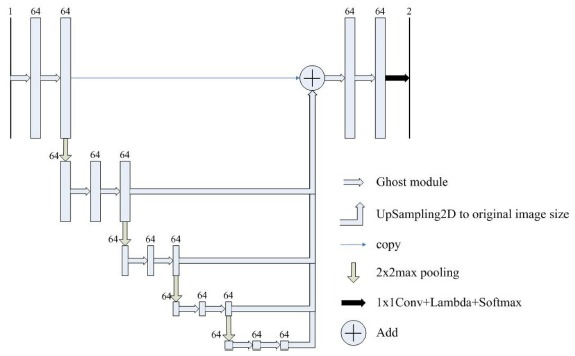

#Data Preprocessing

In [4]:
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
#from read_data import load_images
from keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [5]:
def three_to_two(path, label='FALSE'):
    ff = sorted(glob.glob(path))
    images =[]
    for f in range(len(ff)):
        a = nib.load(ff[f])
        a = a.get_data()
        for i in range(a.shape[2]):
            images.append(a[:,:,i])
    images = np.asarray(images)
    #images = images.reshape(-1, 128,128, 1) # dimension to feed into the network
    return images

def min_max_norm(images):
    m = np.max(images)
    mi = np.min(images)
    images = (images - mi)/ (m - mi)
    return images

def label_outliers(img_labels):
    img_labels[img_labels>1]=1
    img_labels[img_labels<0]=0
    return img_labels

#Image for training
images = three_to_two(path='medical_imaging/tmp/tmp_img/img_new/*')
x_data = min_max_norm(images)

#labels
img_labels = three_to_two(path='medical_imaging/tmp/tmp_img/img_new_label/*')
y_data = label_outliers(img_labels)

#Test Image
img_test = three_to_two(path='medical_imaging/tmp/tmp_img/test_img/*')
x_test = min_max_norm(img_test)

#Test Labels
label_test = three_to_two(path='medical_imaging/tmp/tmp_img/test_img_label/*')
y_test = label_outliers(label_test)

<ipython-input-5-281133919471>:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  a = a.get_data()


In [6]:
def add_label_noise(labels, noise_ratio=0.00):
    flip_indices = np.random.choice(len(labels), size=int(len(labels) * noise_ratio), replace=False)
    # Flip the labels (0->1 and 1->0)
    labels[flip_indices] = 1 - labels[flip_indices]
    return labels

# Adding 1% noise to the training labels
y_data_noisy = add_label_noise(y_data.copy()) # Use .copy() to avoid modifying original y_data


In [7]:
x_data = x_data[:,:,:,np.newaxis] # same as reshape (-1,128,128,1)
y_data = y_data_noisy[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]
y_test = y_test[:,:,:,np.newaxis]

print('Dimension for training data:', x_data.shape)
print('Dimension for training data labels:', y_data.shape)
print('Dimension for test data:', x_test.shape)
print('Dimension for test data labels:', y_test.shape)

Dimension for training data: (3036, 128, 128, 1)
Dimension for training data labels: (3036, 128, 128, 1)
Dimension for test data: (735, 128, 128, 1)
Dimension for test data labels: (735, 128, 128, 1)


In [8]:
import pandas as pd
import numpy as np

# Assuming x_data is your 4-dimensional array
x_data_reshaped = x_data.reshape(x_data.shape[0], -1)  # Flatten the last dimension

# Create DataFrame from reshaped array
df = pd.DataFrame(x_data_reshaped)

# Display the DataFrame
df.head(5)


,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,...,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844
1,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,...,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844
2,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,...,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844
3,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,...,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844
4,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,...,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844,0.059844


#Data Spliting

In [9]:
 from sklearn.utils import shuffle

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2, random_state =42)
x_test, y_test = shuffle(x_test, y_test, random_state= 42)

#Loss Function intilization

In [14]:
import tensorflow.keras.backend as K
def topk_loss(y_true, y_pred):
  k=0.1
  # Calculate the number of pixels to consider
  num_pixels = tf.cast(tf.reduce_prod(tf.shape(y_true)[1:]), tf.float32)
  num_pixels_to_consider = tf.cast(k * num_pixels, tf.int32)
  # Calculate the loss only for the top k% hardest pixels to classify
  loss = -tf.reduce_sum(tf.nn.top_k(tf.reshape(y_true * y_pred, [-1]), num_pixels_to_consider).values)
  return loss

# Example usage:
# Assuming y_true and y_pred are your ground truth and predicted segmentation masks respectively
# k = 0.1 (considering top 10% of pixels)
# loss = topk_loss(y_true, y_pred, k)
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (total_positives + K.epsilon())

def hausdorff_distance(y_true, y_pred):
    surface_distances = tf.reduce_sum(y_true * y_pred, axis=[1, 2]) / tf.reduce_sum(y_true + y_pred, axis=[1, 2])
    hausdorff_distance = tf.reduce_max(surface_distances)
    return hausdorff_distance

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    total_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (total_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (total_positives + K.epsilon())

def hybrid_loss(y_true, y_pred):
    """
    Hybrid loss function combining squared error (SE) and cross-entropy (CE) loss functions.

    """
    s1=0.3
    s2=0.7
    epsilon=1e-6
    # Squared Error (SE) loss
    se_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Cross-Entropy (CE) loss
    ce_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

    # Normalize the error values
    max_se = tf.reduce_max(se_loss)
    max_ce = tf.reduce_max(ce_loss)
    max_se = tf.maximum(max_se, epsilon)
    max_ce = tf.maximum(max_ce, epsilon)

    # Hybridized loss function
    hybrid_loss = s1 * (se_loss / max_se) + s2 * (ce_loss / max_ce)

    return hybrid_loss


beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def logcsh_loss(y_true, y_pred):
    loss = tf.math.log(tf.math.cosh(y_pred - y_true))
    return tf.reduce_mean(loss)

def hybrid(y_true, y_pred):
  s1=0.3
  s2=0.7
  return s1*(dice_coef_loss(y_true, y_pred)) + s2*(logcsh_loss(y_true, y_pred))

#Architecture

In [15]:
np.random.seed = 42
IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS= 128,128,1

In [16]:
import tensorflow as tf,math
from tensorflow.keras import layers, models

def ghost_module(input_tensor, num_filters, ratio=2):
    # Primary convolution
    init_channels = math.ceil(num_filters / ratio)
    primary_conv = layers.Conv2D(init_channels, (3, 3), padding='same')(input_tensor)

    # Cheap operations
    cheap_ops = layers.DepthwiseConv2D((3, 3), padding='same')(primary_conv)
    for _ in range(ratio - 1):
        cheap_ops = layers.DepthwiseConv2D((3, 3), padding='same')(cheap_ops)

    # Concatenate outputs
    output_tensor = layers.concatenate([primary_conv, cheap_ops], axis=-1)
    return output_tensor


In [29]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) ##Used for normailizing the pixal values

#Contraction path
c1 = ghost_module(s, 64, ratio=2)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = ghost_module(c1, 64, ratio=2)
p1 = tf.keras.layers.MaxPooling2D((2, 2), name="Level_1")(c1)

c2 = ghost_module(p1, 64, ratio=2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = ghost_module(c2, 64, ratio=2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = ghost_module(c2, 64, ratio=2)
p2 = tf.keras.layers.MaxPooling2D((2, 2), name="Level_2")(c2)

c3 = ghost_module(p2, 64, ratio=2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = ghost_module(c3, 64, ratio=2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = ghost_module(c3, 64, ratio=2)
p3 = tf.keras.layers.MaxPooling2D((2, 2), name="Level_3")(c3)

c4 = ghost_module(p3, 64, ratio=2)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = ghost_module(c4, 64, ratio=2)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = ghost_module(c4, 64, ratio=2)
p4 = tf.keras.layers.MaxPooling2D((2, 2), name="Level_4")(c4)


c5 = ghost_module(p4, 64, ratio=2)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = ghost_module(c5, 64, ratio=2)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = ghost_module(c5, 64, ratio=2)

#Up Sampling Process
#Expansive path   Decovloution :output_dim = (img - 1) * strides + kernel_size + 2 * padding
#It performs a deconvolution or upconvolution operation, essentially the opposite of a standard convolution.
#padding = same ===> padding = (filter - 1) // 2
"""
Padding == ‘Same’:
Output Height (H) = Input Height (H1) × Stride
Output Width (W) = Input Width (W1) × Stride
Padding == ‘Valid’:
Output Height (H) = (Input Height (H1) - 1) × Stride + Kernel Height (HF) - 2 × p
Output Width (W) = (Input Width (W1) - 1) × Stride + Kernel Width (WF) - 2 × p
"""

u5 = tf.keras.layers.UpSampling2D(size=(16, 16),name="U5")(c5)
u4 = tf.keras.layers.UpSampling2D(size=(8, 8) ,name ="U4")(c4)
u3 = tf.keras.layers.UpSampling2D(size=(4, 4) ,name ="U3")(c3)
u2 = tf.keras.layers.UpSampling2D(size=(2, 2), name="U2")(c2)

add = tf.keras.layers.Add()([u2,u3,u4,u5,c1])
#add = tf.expand_dims(add, axis=0)  # Add a batch dimension

c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name = "C6")(add)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name = "C7")(c6)




outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', name="output_layer")(c7)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(1e-2), loss='binary_crossentropy', metrics=[dice_coef,jaccard_index,precision,specificity,hausdorff_distance,recall,sensitivity,'accuracy'])

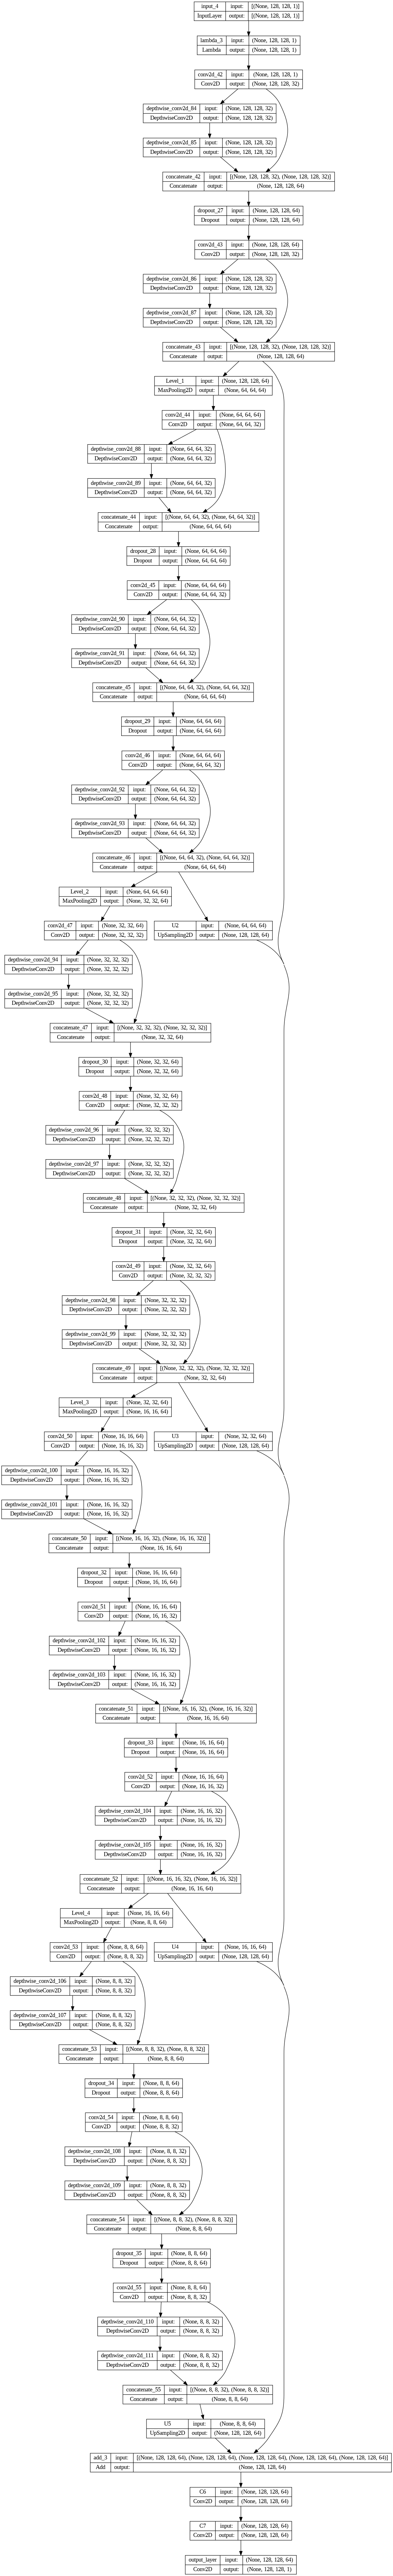

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True)


In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# Define your callbacks
filepath = 'saved_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'  # Define the filepath with proper placeholders
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')  # Save the model with the highest validation accuracy
#early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)  # Logging to CSV file


In [31]:

# Assuming model is defined elsewhere
results = model.fit(x_data, y_data, validation_data=(x_val, y_val),
                    batch_size=16, epochs=20, callbacks=[checkpoint, log_csv])


Epoch 1/20
190/190 [==============================] - ETA: 0s - loss: 473023.3750 - dice_coef: 0.0991 - jaccard_index: 0.0524 - precision: 0.0015 - specificity: 0.9758 - hausdorff_distance: nan - recall: 0.0219 - sensitivity: 0.0219 - accuracy: 0.9013
Epoch 1: val_accuracy improved from -inf to 0.91823, saving model to saved_models/weights-improvement-01-0.92.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


190/190 [==============================] - 51s 153ms/step - loss: 473023.3750 - dice_coef: 0.0991 - jaccard_index: 0.0524 - precision: 0.0015 - specificity: 0.9758 - hausdorff_distance: nan - recall: 0.0219 - sensitivity: 0.0219 - accuracy: 0.9013 - val_loss: 0.3198 - val_dice_coef: 0.0976 - val_jaccard_index: 0.0514 - val_precision: 0.0000e+00 - val_specificity: 0.9990 - val_hausdorff_distance: 0.0979 - val_recall: 0.0000e+00 - val_sensitivity: 0.0000e+00 - val_accuracy: 0.9182
Epoch 2/20
190/190 [==============================] - ETA: 0s - loss: 0.2739 - dice_coef: 0.0870 - jaccard_index: 0.0456 - precision: 0.0000e+00 - specificity: 0.9994 - hausdorff_distance: 0.0820 - recall: 0.0000e+00 - sensitivity: 0.0000e+00 - accuracy: 0.9209
Epoch 2: val_accuracy did not improve from 0.91823
190/190 [==============================] - 26s 136ms/step - loss: 0.2739 - dice_coef: 0.0870 - jaccard_index: 0.0456 - precision: 0.0000e+00 - specificity: 0.9994 - hausdorff_distance: 0.0820 - recall: 0

#Ploting Loss Functions

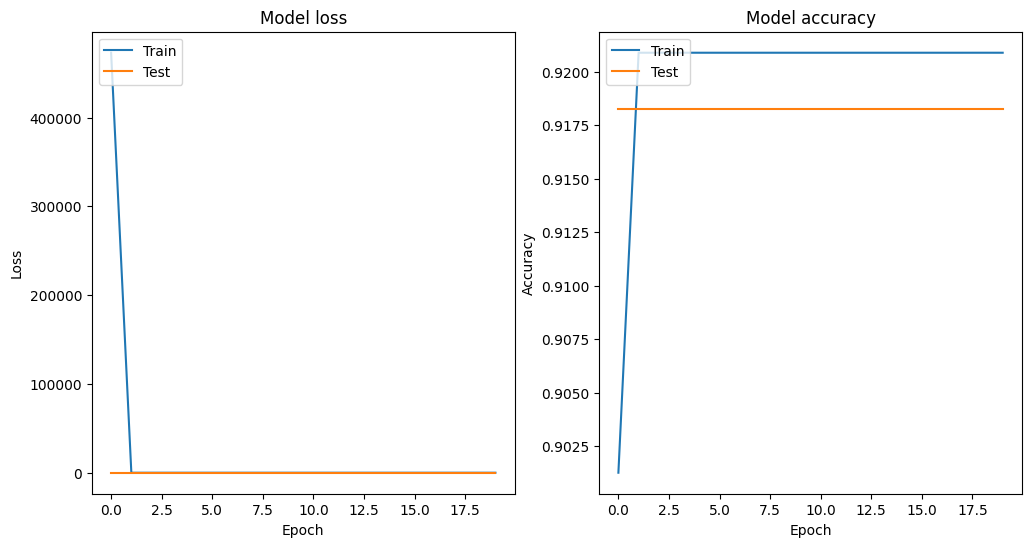

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
